In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# from hyperopt.pyll import scope
from sklearn.model_selection import cross_val_score

# Params
train_indx = 150000
params_tunning_num_eval = 75

# Seed
random_state = 42

In [120]:
def logreg_hyperparam_opt(param_space, trainX, trainY, testX, testY, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        model = LogisticRegression(max_iter=10000, solver='liblinear', **params)
        score = cross_val_score(model, trainX, trainY, cv=5, scoring='roc_auc').mean()
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function,
                      param_space,
                      algo=tpe.suggest,
                      max_evals=num_eval,
                      trials=trials,
                      rstate=np.random.default_rng(42))
    loss = [x['result']['loss'] for x in trials.trials]
    
    return best_param

In [118]:
def dectree_hyperparam_opt(param_space, trainX, trainY, testX, testY, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        model = DecisionTreeClassifier(**params)
        score = cross_val_score(model, trainX, trainY, cv=5, scoring='roc_auc').mean()
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function,
                      param_space,
                      algo=tpe.suggest,
                      max_evals=num_eval,
                      trials=trials,
                      rstate=np.random.default_rng(42))
    loss = [x['result']['loss'] for x in trials.trials]
    
    return best_param

In [140]:
def write_submission(model, model_name):
    model.fit(train, label)
    res = pd.DataFrame(model.predict_proba(test))
    res.drop(columns=[0], inplace=True)
    res.index = res.index + 1
    res.index.rename('Id', inplace=True)
    res.rename(columns={1: 'Probability'}, inplace=True)
    res.to_csv(f'{model_name}.csv')

In [25]:
# Load training and testing sets
train = pd.read_csv('data/cs-training.csv')
test = pd.read_csv('data/cs-test.csv')

In [4]:
train.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

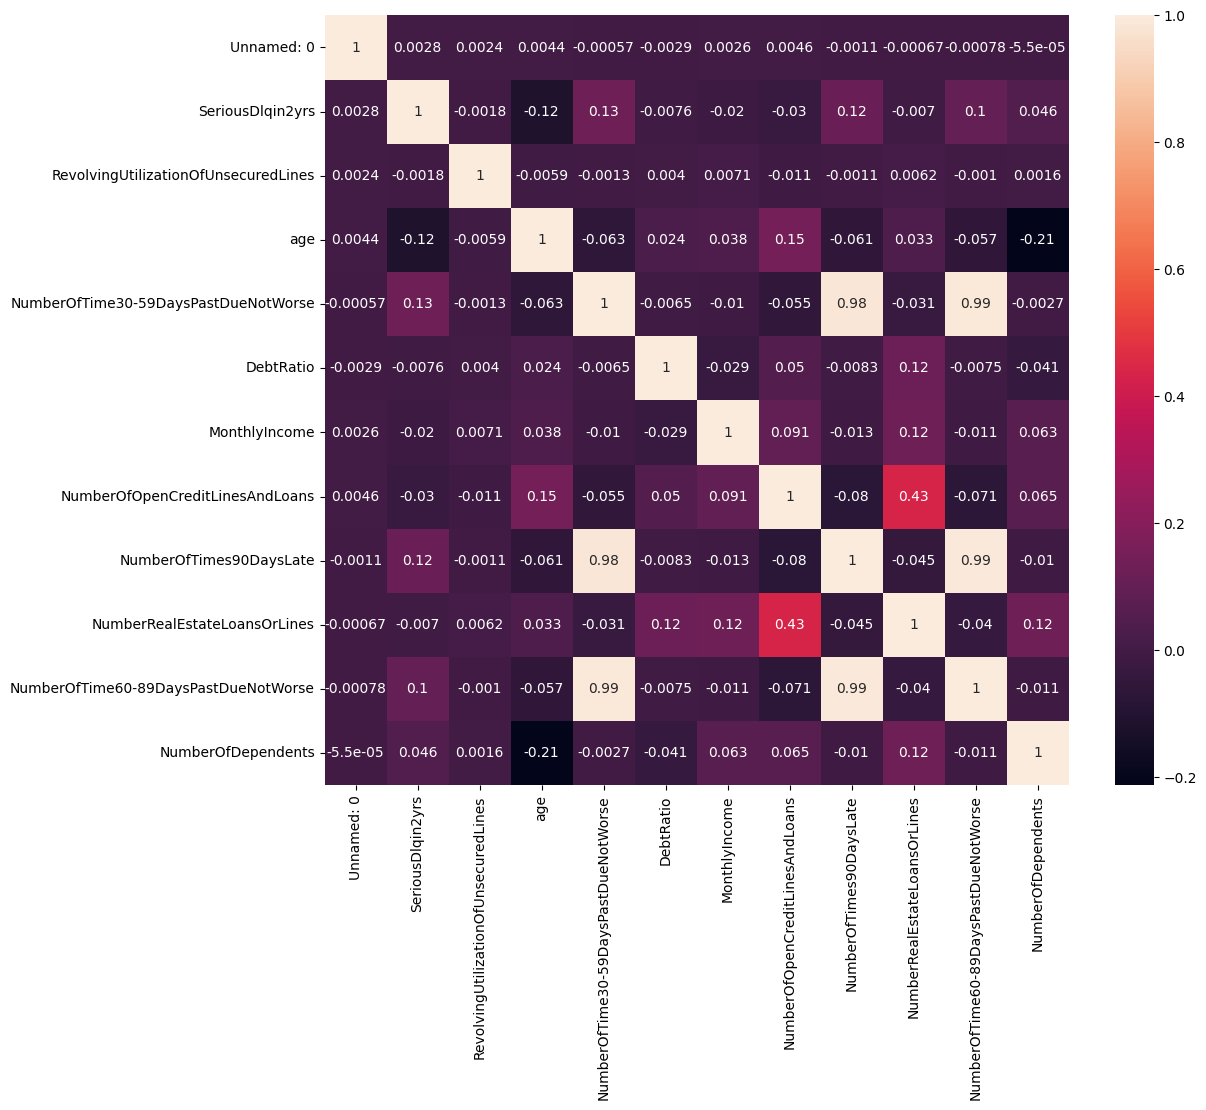

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True);

# Feature Engineering

In [26]:
label = train['SeriousDlqin2yrs']
train.drop(columns=['SeriousDlqin2yrs', 'Unnamed: 0'], inplace=True)
test.drop(columns=['SeriousDlqin2yrs', 'Unnamed: 0'], inplace=True)

test.index = np.arange(np.max(train.index)+1, np.max(train.index)+test.shape[0]+1)
dataset = pd.concat([train, test])

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Simple preprocessing
median_impt = SimpleImputer(strategy='median')
imp_cols = ['MonthlyIncome', 'NumberOfDependents']
for col in imp_cols:
    median_impt.fit(train[[col]])
    dataset[[col]] = median_impt.transform(dataset[[col]])

# Creating new features
dataset['DebtExpense'] = dataset['MonthlyIncome'] * dataset['DebtRatio']
dataset['NetIncome'] = dataset['MonthlyIncome'] - dataset['DebtExpense']
dataset['NetIncomeRatio'] = dataset['NetIncome'] / dataset['MonthlyIncome']
dataset['NumberOfOtherCreditLinesAndLoans'] = dataset['NumberOfOpenCreditLinesAndLoans'] - dataset['NumberRealEstateLoansOrLines']
dataset['MonthlyIncome&NumberOfDependents'] = dataset['MonthlyIncome'] * dataset['NumberOfDependents']
dataset['TotalNumberOfDPD'] = dataset['NumberOfTime30-59DaysPastDueNotWorse'] + dataset['NumberOfTime60-89DaysPastDueNotWorse'] + \
                              dataset['NumberOfTimes90DaysLate']

# Log transform
dataset['LogDebtRatio'] = np.log(dataset['DebtRatio'])
dataset['LogNumberOfOpenCreditLinesAndLoans'] = np.log(dataset['NumberOfOpenCreditLinesAndLoans'])

# Scaling transform
sclr_cols = ['MonthlyIncome', 'RevolvingUtilizationOfUnsecuredLines']
scaler = StandardScaler()
for col in sclr_cols:
    scaler.fit(train[[col]])
    dataset[[col]] = scaler.transform(dataset[[col]])

C:\Users\Hieu Trieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
dataset.iloc[:train.shape[0],:]

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtExpense,NetIncome,NetIncomeRatio,NumberOfOtherCreditLinesAndLoans,MonthlyIncome&NumberOfDependents,TotalNumberOfDPD,LogDebtRatio,LogNumberOfOpenCreditLinesAndLoans
0,-0.021150,45,2,0.802982,-0.463693,13,0,6,0,2.0,0.136752,0.033553,0.197018,7,0.340611,2,-0.219423,2.564949
1,-0.020385,40,0,0.121876,-0.463725,4,0,0,0,1.0,-0.034486,-0.248471,0.878124,4,-0.282957,0,-2.104749,1.386294
2,-0.021582,38,1,0.085113,-0.463723,2,1,0,0,0.0,-0.021468,-0.230761,0.914887,2,-0.000000,2,-2.463771,0.693147
3,-0.023281,30,0,0.036050,-0.463722,5,0,0,0,0.0,-0.008446,-0.225847,0.963950,5,-0.000000,0,-3.322857,1.609438
4,-0.020585,49,1,0.024926,-0.463430,7,0,1,0,0.0,0.098627,3.858224,0.975074,6,0.000000,1,-3.691856,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,-0.024055,74,0,0.225131,-0.463727,4,0,1,0,0.0,-0.071528,-0.246188,0.774869,3,-0.000000,0,-1.491073,1.386294
149996,-0.023017,44,0,0.716562,-0.463711,4,0,1,0,2.0,-0.054110,-0.021403,0.283438,3,-0.151025,0,-0.333290,1.386294
149997,-0.023232,58,0,3870.000000,-0.463711,18,0,1,0,0.0,-341.737084,341.648780,-3869.000000,17,-0.000000,0,8.261010,2.890372
149998,-0.024218,30,0,0.000000,-0.463710,4,0,0,0,0.0,-0.000000,-0.066336,1.000000,4,-0.000000,0,-inf,1.386294


In [38]:
from sklearn.model_selection import train_test_split

train = dataset.iloc[:train.shape[0],:]
test = dataset.iloc[train.shape[0]:,:]
trainX, valX, trainY, valY = train_test_split(train, label, train_size=.8, stratify=label,
                                              random_state=random_state)
print(trainX.shape)
print(valX.shape)
print(trainY.shape)
print(valY.shape)

(120000, 18)
(30000, 18)
(120000,)
(30000,)


# Logistic Regression

## Baseline

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

""" 
As class 1 is the majority in our dataset, we can create a naive/baseline model which will 
random guess all observations in the validation set as 1 and compare it against other more
sophiticated models
"""
baseline = np.ones(valY.shape[0])

print(f'Accuracy: {accuracy_score(valY, baseline)}')
print(f'AUC: {roc_auc_score(valY, baseline)}')

Accuray: 0.06683333333333333
AUC: 0.5


In [ ]:
# Public: 0.70313
# Private: 0.69647

In [38]:
res

{'C': 1.3311666797797326, 'penalty': 1}

## Hyperparameters tuning

In [133]:
logreg_params = {
    'penalty': hp.choice('penalty', ['l2', 'l1']),
    'C': hp.loguniform('C', 1e-3, 1)
                }

best_params = logreg_hyperparam_opt(logreg_params, trainX, trainY, valX, valY, num_eval)

100%|███████████████████████████████████████████████| 75/75 [10:37<00:00,  8.50s/trial, best loss: -0.6934762280304891]


In [134]:
best_params

{'C': 1.9876573599514489, 'penalty': 1}

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

baseline_logreg = LogisticRegression(solver='liblinear', max_iter=10000, C=1.9876573599514489, penalty='l1')

baseline_logreg.fit(trainX, trainY)
print(f'AUC: {roc_auc_score(valY, baseline_logreg.predict_proba(valX)[:, 1])}')

AUC: 0.714299142303199


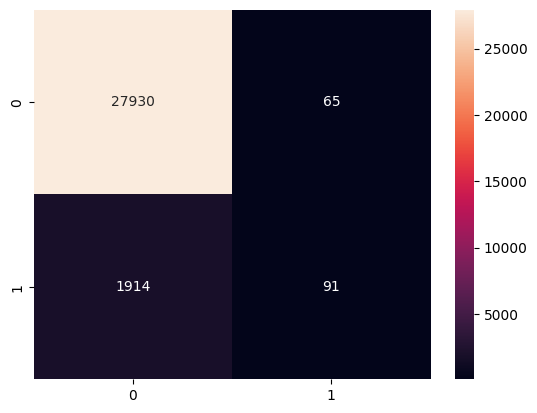

In [136]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(valY, baseline_logreg.predict(valX)), annot=True, fmt=".0f");

# Decision Tree

In [75]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(trainX, trainY)
print(f'AUC: {roc_auc_score(valY, dec_tree.predict_proba(valX)[:, 1])}')

AUC: 0.6088620741413122


In [127]:
dectree_params = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 32, 1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
    'min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1, 50)),
    'min_samples_split': hp.uniform('min_samples_split', 0, 1)
                }

best_params = dectree_hyperparam_opt(dectree_params, trainX, trainY, valX, valY, num_eval)

100%|███████████████████████████████████████████████| 75/75 [00:47<00:00,  1.59trial/s, best loss: -0.8524906569137807]


In [128]:
best_params

{'max_depth': 30.0,
 'min_samples_leaf': 33.95178889779289,
 'min_samples_split': 0.029852552071673238,
 'min_weight_fraction_leaf': 0.0031396860135927407}

In [137]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(max_depth=30,
                                  min_samples_leaf=34,
                                  min_samples_split=0.029852552071673238,
                                  min_weight_fraction_leaf=0.0031396860135927407)
dec_tree.fit(trainX, trainY)
print(f'AUC: {roc_auc_score(valY, dec_tree.predict_proba(valX)[:, 1])}')

AUC: 0.8562398878674007


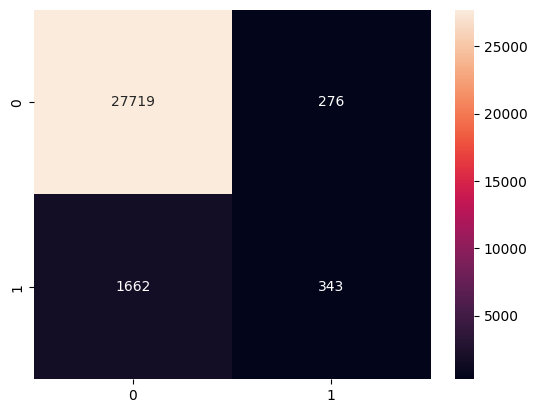

In [139]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(valY, dec_tree.predict(valX)), annot=True, fmt=".0f");

In [141]:
write_submission(dec_tree, 'DecisionTree')